## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with training a softmax classifier.

In [1]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [3]:
from nndl import Softmax

In [4]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [5]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [6]:
print(loss)

2.3277607028048966


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

Since normalized softmax loss is about 2.3, this means on average each sample has a loss of about 2.3, or the softmax likelihood is $e^{-2.3} \approx 0.1$.It makes sense that the probability that a training sample belonging to one of the 10 classes is approximately 0.1, because the weights of the softmax classifier were initialized randomly and not trained, so the classifier is expected to perform only about as well as random selection.

#### Softmax gradient

In [48]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: -0.689809 analytic: -0.689809, relative error: 1.134504e-07
numerical: -0.953264 analytic: -0.953264, relative error: 2.886830e-08
numerical: -0.706163 analytic: -0.706163, relative error: 6.701976e-08
numerical: -1.369201 analytic: -1.369201, relative error: 1.770297e-08
numerical: 0.239378 analytic: 0.239378, relative error: 7.813492e-08
numerical: -0.737377 analytic: -0.737377, relative error: 5.281970e-08
numerical: 0.760432 analytic: 0.760432, relative error: 1.740682e-08
numerical: -0.101912 analytic: -0.101912, relative error: 2.210229e-07
numerical: 0.298371 analytic: 0.298371, relative error: 6.020171e-08
numerical: -0.711695 analytic: -0.711695, relative error: 2.067060e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [9]:
import time

In [51]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} / {} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 1.8046791536275602 / 126.02471979493755 computed in 0.09175419807434082s
Vectorized loss / grad: 1.8046791536275624 / 126.02471979493754 computed in 0.070770263671875s
difference in loss / grad: -2.220446049250313e-15 / 3.088195742542178e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

## Question:

How should the softmax gradient descent training step differ from the svm training step, if at all?

## Answer:

Ignore (according to Piazza).

iteration 0 / 1500: loss 2.2994882822736993
iteration 100 / 1500: loss 2.042490550175762
iteration 200 / 1500: loss 2.027844852497281
iteration 300 / 1500: loss 1.9179261462805273
iteration 400 / 1500: loss 1.9076548044880985
iteration 500 / 1500: loss 1.9329102671933542
iteration 600 / 1500: loss 1.815945601677181
iteration 700 / 1500: loss 1.7579916747556756
iteration 800 / 1500: loss 1.80188193436167
iteration 900 / 1500: loss 1.8767744414545127
iteration 1000 / 1500: loss 1.7101926466616824
iteration 1100 / 1500: loss 1.8991429930117618
iteration 1200 / 1500: loss 1.850237251793591
iteration 1300 / 1500: loss 1.913509261822181
iteration 1400 / 1500: loss 1.7799013879472512
That took 40.684062242507935s


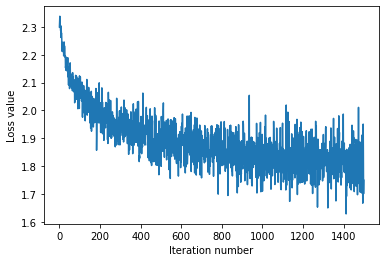

In [33]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [34]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3833673469387755
validation accuracy: 0.382


## Optimize the softmax classifier

You may copy and paste your optimization code from the SVM here.

In [35]:
np.finfo(float).eps

2.220446049250313e-16

In [41]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the Softmax classifier that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #

learning_rates = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
best_rate = 0
best_accuracy = 0

for learning_rate in learning_rates:
    print('learning rate: {}'.format(learning_rate))
    softmax.train(X_train, y_train, learning_rate=learning_rate, num_iters=1500, verbose=False)
    
    y_train_pred = softmax.predict(X_train)
    print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
    
    y_val_pred = softmax.predict(X_val)
    val_accuracy = np.mean(np.equal(y_val, y_val_pred))
    print('validation accuracy: {}\n'.format(val_accuracy, ))

    if val_accuracy > best_accuracy:
        best_rate = learning_rate
        best_accuracy = val_accuracy

print("Best learning rate / best validation accuracy: {} / {}". format(best_rate, best_accuracy))

softmax.train(X_train, y_train, learning_rate=1e-7, num_iters=1500, verbose=False)
y_test_pred = softmax.predict(X_test)
print('Test accuracy: {}'.format(np.mean(np.equal(y_test, y_test_pred)), ))

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


learning rate: 0.0001
training accuracy: 0.33722448979591835
validation accuracy: 0.322

learning rate: 1e-05
training accuracy: 0.3604081632653061
validation accuracy: 0.337

learning rate: 1e-06
training accuracy: 0.42083673469387756
validation accuracy: 0.409

learning rate: 1e-07
training accuracy: 0.37948979591836735
validation accuracy: 0.383

learning rate: 1e-08
training accuracy: 0.2857959183673469
validation accuracy: 0.28

learning rate: 1e-09
training accuracy: 0.17283673469387756
validation accuracy: 0.17

learning rate: 1e-10
training accuracy: 0.10916326530612244
validation accuracy: 0.107

Best learning rate / best validation accuracy: 1e-06 / 0.409
Test accuracy: 0.389
